<a href="https://colab.research.google.com/github/DCEG-workshops/statgen_workshop_tutorial/blob/main/src/03_FineMapping%26Colocalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Overview**

In this exercise, first we will be using fine-mapping (SuSiE) to identify the potential set of "statistically" causal variants in a particular region. Then we will use colocalization to evaluate whether a GWAS signal and eQTL association are driven by the same causal variant. We will go over two examples of this.

The entire exercise will be based on variant level summary statistics extracted from GWAS and eQTL studies.



## **Setup**
Before we get started, make sure you have the statgen_workshop folder added to your drive. See the link and screenshot below if you need help with this step.

*Important: We want to mount the google drive* for the data neeed for this workshop. Please open this link with your Google drive and find the "statgen_workshop" folder under "Share with me". Then add a shortcut to the folder under "My Drive", as shown in the screenshot.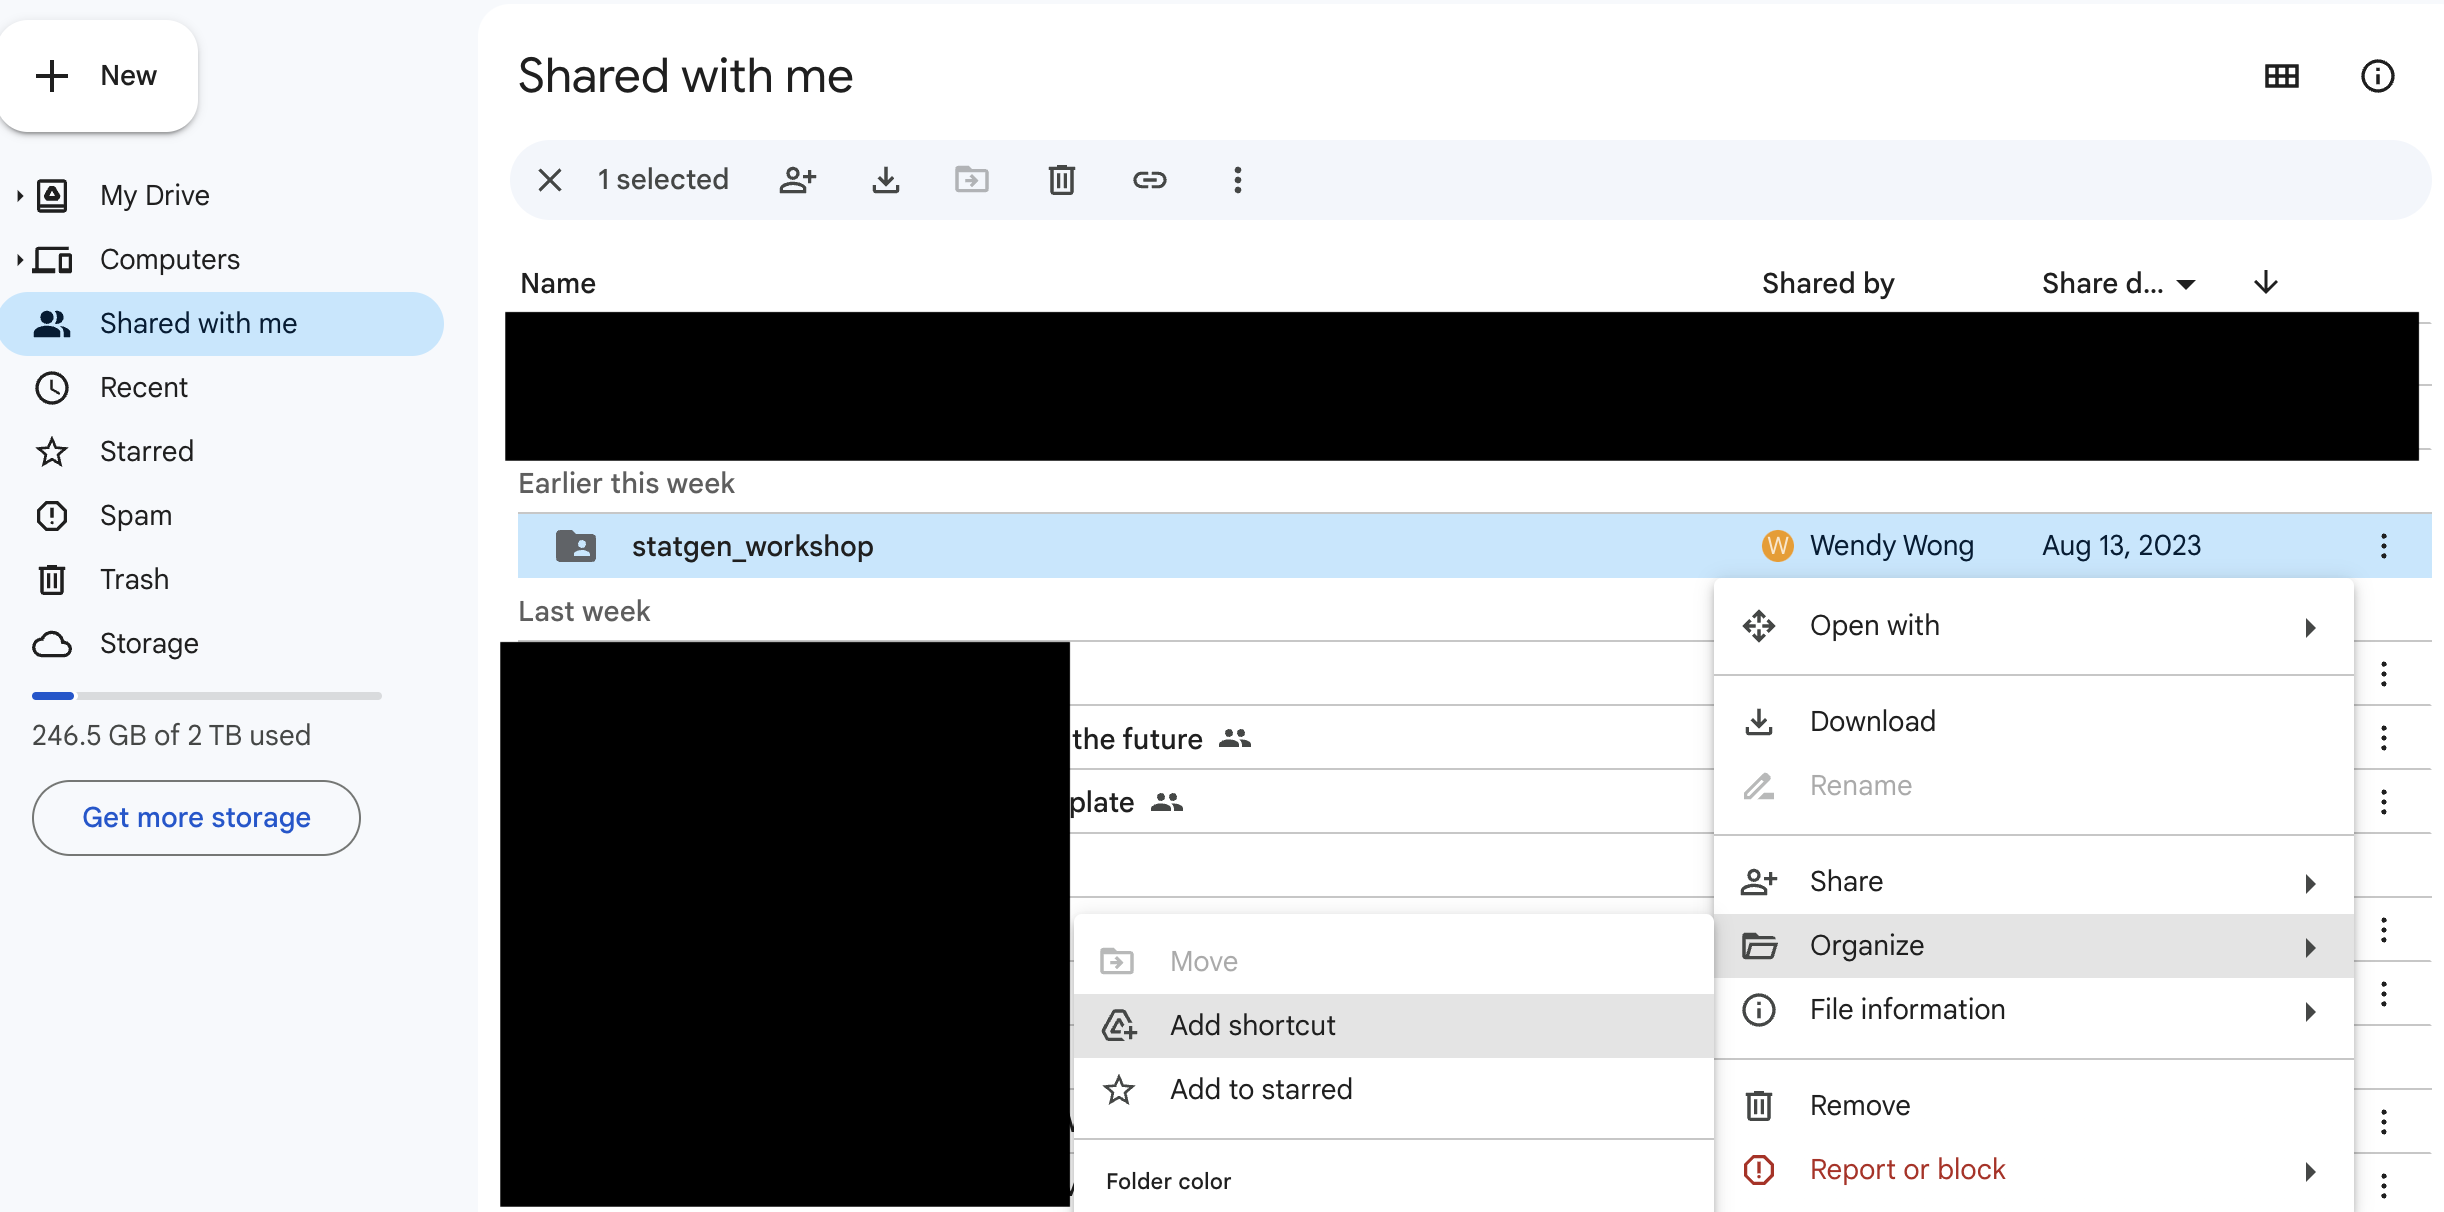


When you import the drive, your google will popup a security alert. Be sure to grant yourself access.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Now we can look at the contents of the drive using the list (ls) command and verify the drive is added to "MyDrive"

In [ ]:
!ls /content/drive/MyDrive/statgen_workshop/data/workshop3/

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R

install.packages("susieR")
install.packages("coloc")

In [ ]:
%%R
library(susieR); library(coloc); library(glue)

In [ ]:
import os
input_dir="/content/drive/MyDrive/statgen_workshop/data/workshop3/"
os.environ['input_dir']=input_dir

In [ ]:
%%bash
ls ${input_dir}

Read in and view the summary statistics of the region.

This is a local/regional manhattan plot for association in Biobank Japan for Breast Cancer and variants around the gene *FGFR2*.

In [ ]:
%%R -i input_dir

ss = read.table(glue(input_dir,"example_1_sumstat.txt"),header = T)
n.snp = dim(ss)[1]
print(head(ss[order(ss$p.value),]))

Now, lets read in and view the LD matrix.  

The usual command to get that is

plink --bfile GENOTYPE_FILE --keep-allele-order --extract SNP_LIST --r bin4

In PLINK outputs, generally the LD matrix is provided in .bin (binary) format.

However, we want the correlation matrix not the r2 matrix generated by --r bin4 option.

In [ ]:
%%R

ld = readBin(glue(input_dir,"example_1_LD.ld.bin"), what="numeric", size=4, n=(n.snp)^2)
ld = matrix(ld,ncol = n.snp,byrow = T)
ld[is.na(ld)] = 0
print(round(ld[1:6,1:6],3))

We will first take a look at the local/regional manhattan plot to get a sense of the associations in the region. We will color each of the SNPs by its LD (r2) with the index or sentinel variant (SNP with the lowest p-value).

It is always important to get a sense of the association patterns in the region before diving into the analysis.

In [ ]:
%%R

indx <- which.min(ss$p.value)
ldx <- abs(ld[,indx])^2
colsx = cut(ldx^2,breaks = c(0,0.2,0.4,0.6,0.8,1))
levels(colsx) = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2")
plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),cex = 0.8,main = "chr 10q26",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = "darkmagenta",pch = 18,cex = 1.5)
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","sentinel"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")

Now lets run SuSiE

In [ ]:
%%R

s1 = susie_rss(bhat=ss$BETA,shat = ss$SE,R = ld,estimate_residual_variance= F,L = 10)
summary(s1)

In [ ]:
%%R
str(s1)

In [ ]:
%%R

ss$pip = s1$pip

head(ss[order(ss$pip,decreasing = T),c(2,3,4,11,12,14,21)])

In [ ]:
%%R

cols.pip <- rep("antiquewhite2",dim(ss)[1])
cols.pip[s1$sets$cs$L1] <- "chocolate4"
plot(ss$POS,s1$pip,col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "PIP",cex = 0.8,bty = "n",ylim = c(0,0.8), main = "Fine-mapping: chr 10q26")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = s1$pip[indx],col = cols.pip[indx],pch = 18,cex = 1.5)
legend("topright",legend = c("credible set 1","not in credible set"), col = c("chocolate4","antiquewhite2"),pch = 19)

In [ ]:
%%R

plot(ss$POS,-log10(ss$p.value),col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),cex = 0.8,main = "chr 10q26",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("credible set 1","not in credible set"), col = c("chocolate4","antiquewhite2"),pch = 19)

In [ ]:
%%R

library(coloc)

ss = read.table(glue(input_dir,"example_1_sumstat.txt"),header = T)
ss.H4 = read.table(glue(input_dir,"gene_expression_tissue1.txt"),header = T)

dx1 = list()
dx1$beta <- ss$BETA
dx1$varbeta <- ss$SE^2
dx1$pvalues <- ss$p.value
dx1$snp <- ss$SNPID
dx1$N <- 200000
dx1$type <- "cc"
dx1$s <- 0.033
check_dataset(dx1)

dx2 <- list()
dx2$pvalues <- ss.H4$p.value; dx2$N <- 670; dx2$MAF <- ifelse(ss.H4$effect_allele_frequency > 0.5,yes = 1- ss.H4$effect_allele_frequency,no = ss.H4$effect_allele_frequency)
dx2$type <- "quant";dx2$sdY <- 1; dx2$snp <- ss.H4$rsid

coloc.abf(dx1,dx2)

plot(ss.H4$pos,-log10(ss.H4$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,40),cex = 0.8,main = "Gene Expression: chr 10q26",bty = "n")
axis(1,at = c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos)),labels = round(c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos))/1000000,2))
points(x = ss.H4$pos[indx],y = -log10(ss.H4$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","sentinel"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")

plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),cex = 0.8,main = "Disease: chr 10q26",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)


In [ ]:
%%R

ss.H4 = read.table(glue(input_dir,"gene_expression_tissue2.txt"),header = T)

print(head(ss.H4))



In [ ]:
%%R

dx1 = list()
dx1$beta <- ss$BETA
dx1$varbeta <- ss$SE^2
dx1$pvalues <- ss$p.value
dx1$snp <- ss$SNPID
dx1$N <- 200000
dx1$type <- "cc"
dx1$s <- 0.033
check_dataset(dx1)

dx2 <- list()
dx2$pvalues <- ss.H4$p.value; dx2$N <- 300; dx2$MAF <- ifelse(ss.H4$effect_allele_frequency > 0.5,yes = 1- ss.H4$effect_allele_frequency,no = ss.H4$effect_allele_frequency)
dx2$type <- "quant";dx2$sdY <- 1; dx2$snp <- ss.H4$rsid

coloc.abf(dx1,dx2)


plot(ss.H4$pos,-log10(ss.H4$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,40),cex = 0.8,main = "Gene Expression: chr 10q26",bty = "n")
axis(1,at = c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos)),labels = round(c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos))/1000000,2))
points(x = ss.H4$pos[indx],y = -log10(ss.H4$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)

plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),cex = 0.8,main = "Disease: chr 10q26",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("credible set 1","not in credible set"), col = c("chocolate4","antiquewhite2"),pch = 19)

In [ ]:
%%R -i input_dir

library(susieR)
library(glue)
ss = read.table(glue(input_dir,"example_2_sumstat.txt"),header = T)
n.snp = dim(ss)[1]

print(head(ss[order(ss$p.value),]))

ld = readBin(glue(input_dir,"example_2_LD.ld.bin"), what="numeric", size=4, n=(n.snp)^2)
ld = matrix(ld,ncol = n.snp,byrow = T)
ld[is.na(ld)] = 0
s1 = susie_rss(bhat=ss$beta,shat = ss$standard_error,R = ld,estimate_residual_variance= F,L = 10)
summary(s1)

In [ ]:
%%R -i input_dir
indx <- which.min(ss$p.value)
ldx <- abs(ld[,indx])^2
colsx = cut(ldx^2,breaks = c(0,0.2,0.4,0.6,0.8,1))
levels(colsx) = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2")
table(colsx)
plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,20),cex = 0.8,main = "chr 5p15.33",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = "darkmagenta",pch = 18,cex = 1.5)


In [ ]:
%%R -i input_dir

cols.pip <- rep("antiquewhite2",dim(ss)[1])
cols.pip[s1$sets$cs$L1] <- "dodgerblue2"
cols.pip[s1$sets$cs$L2] <- "firebrick2"

print(s1$sets$cs)
plot(ss$POS,s1$pip,col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "PIP",cex = 0.8,bty = "n",ylim = c(0,0.8), main = "Fine mapping: chr 5p13.33")
points(x = ss$POS[indx],y = s1$pip[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("credible set 1", "credible set 2","not in credible set"), col = c("dodgerblue2","firebrick2","antiquewhite2"),pch = 19)

In [ ]:
%%R
print(round(ld[s1$sets$cs$L1,s1$sets$cs$L1],2))
print(round(ld[s1$sets$cs$L1,s1$sets$cs$L2],3))

In [ ]:
%%R
plot(ss$POS,-log10(ss$p.value),col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,15),cex = 0.8,main = "chr 5p15.33",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("credible set 1", "credible set 2","not in credible set"), col = c("dodgerblue2","firebrick2","antiquewhite2"),pch = 19)

Challenge: How would you perform colocalization on this dataset?

Note: the assumption of coloc is a single causal variant.

Hint: Look at [this page](https://cran.r-project.org/web/packages/coloc/vignettes/a06_SuSiE.html)

Idea: Use SuSiE to partition the locus into separate distinctive signals. Use coloc on each of the distinct signals.